In [1]:
import datacube
dc = datacube.Datacube(config='/g/data/u46/users/brl654/datacube/simoncube.conf')

In [2]:
%matplotlib inline
import pickle
import numpy as np

# Find and inspect one layer

In [3]:
ds = dc.find_datasets(product='s1_gamma0_scene')[3] # grab metadata record concerning an example dataset/layer
ds.center_time # find what time it corresponds to

datetime.datetime(2017, 4, 15, 19, 51, 53, 566905)

In [4]:
lon = 145.5895, 146.0649
lat = -17.53, -16.7007
x = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, time=ds.center_time, output_crs='epsg:3577', resolution=(-25,25)) # load that one layer
x

<xarray.Dataset>
Dimensions:  (time: 1, x: 2413, y: 3861)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-15T19:51:53.566905
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0275116 0.0315146 0.0429633 0.0525707 ...
    vv       (time, y, x) float32 0.395897 0.216501 0.150688 0.11122 ...
Attributes:
    crs:      epsg:3577

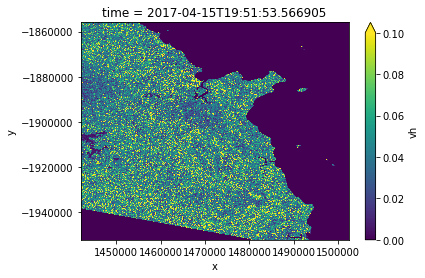

In [5]:
x.vh[:,::2,::2].plot(vmax=0.1)

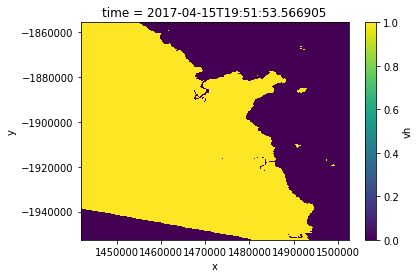

In [6]:
(x.vh != x.vh.nodata)[:,::10,::10].plot()

# Obtain all layers

Expected to take 5 to 10 minutes.

In [7]:
#z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))

In [8]:
#import pickle
#with open('/g/data1/w85/sj9724/xarray.pickle', 'wb') as file:
#    pickle.dump(z, file, protocol=-1) # write xarray to disk

In [9]:
#with open('/g/data1/w85/sj9724/xarray.pickle', 'rb') as file:
    #z = pickle.load(file) # this only takes tens of seconds. (~6GB)

# .... Revised section - Obtain all Layers

In [10]:
#cache = '/g/data/u46/users/brl654/radar/larry_gradproj/xarray.pickle.2'
cache = '/g/data1/w85/sj9724/xarray.pickle'
try:
    with open(cache, 'rb') as file:
        z = pickle.load(file) # this only takes tens of seconds. (6GB)
except:
    # this may be 5 to 10 mintues (seeking through half a terabyte)
    z = dc.load(product='s1_gamma0_scene', lat=lat, lon=lon, output_crs='epsg:3577', resolution=(-25,25))
    with open(cache, 'wb') as file:
        pickle.dump(z, file, protocol=-1) # save result to disk

# Count observations
Patterns in the observation count often explain flaws in downstream products.

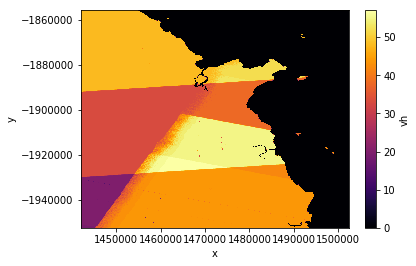

In [11]:

counts = (z.vh!=z.vh.nodata).sum(dim='time')
counts[::4,::4].plot(cmap='inferno')

# Average signal
A naive mean will fail to account for different numbers of observations in different areas.

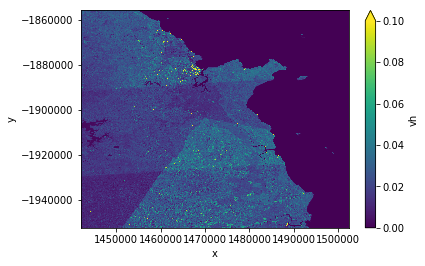

In [12]:
z.vh[:,::4,::4].mean(dim='time').plot(vmax=0.1)

In [13]:
x.vh.nodata

0

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


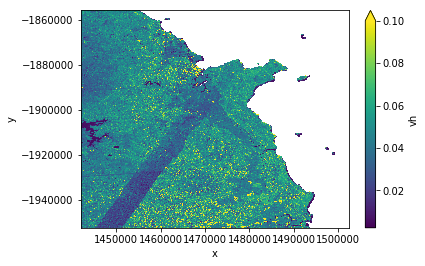

In [14]:
average = (z.vh[:,::4,::4].sum(dim='time') / counts)
average.plot(vmax=0.1)

# Problem 1 - Steps - Identification - Solution

The above image has a strip of "problem" data. 
The following steps were taken to identify the problem -

In [15]:
#average[700:800,100:200].plot(vmax=0.1) # Zooming in on a section of the problem area

In [16]:
#counts[::4,::4][700:800,100:200].plot() #Looking for all x all y every 4th step

Looking at the times where nodata - identify layers to zoom into

In [17]:
#(z.vh!=z.vh.nodata)[:,::4,::4][:,700:800,100:200].sum(dim=['x','y']).plot(marker='o') 

Following 3 steps - analysis and comparison of images to identify 'problem' time steps
1a. Look at last 10 time layers - 5 columns then wrap to next 5 - identify images that show 'bleeding' between areas of data/nodata
1b.Displaying the 'bleeding' time images
2.

In [18]:
#(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5) #1a.

In [19]:
#(z.vh!=z.vh.nodata)[:,::4,::4][-10:,700:800,100:200].time #1b.show the time of the 'bleeding' images

In [20]:
#(z.vh)[:,::4,::4][-10:,700:800,100:200].plot(col='time', col_wrap=5, vmax=0.1)

# problem identified - areas where the data is very close to zero but not quite zero

In [21]:
#problem = z.sel(time='2017-04-10T19:44:05.949922000').vh[::4,::4].copy()
#problem.data[problem.data==0] = np.nan
#problem.plot(vmax=0.00001)
#(problem < 0.0001).plot() # problem identified - areas where the data is very close to zero but not quite

# Solution -
We now run the same script that produced the 'problem' image but define where there is data >0.001.  Voilà! Clean image

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


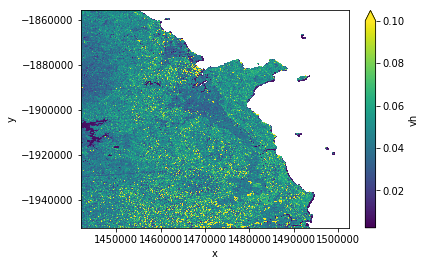

In [22]:
new_counts = (z.vh>0.001).sum(dim='time')
new_average = (z.vh[:,::4,::4].sum(dim='time') / new_counts)
new_average.plot(vmax=0.1)

In [ ]:
# write out the pickled file
with open('/g/data1/w85/sj9724/average_radar', 'wb') as file:
    radar = pickle.dump(new_average, file)

In [ ]:
# clear everything in memory and start over with the created files

In [23]:
import pickle
with open('/g/data1/w85/sj9724/average_radar', 'rb') as file:
    radar = pickle.load(file) 


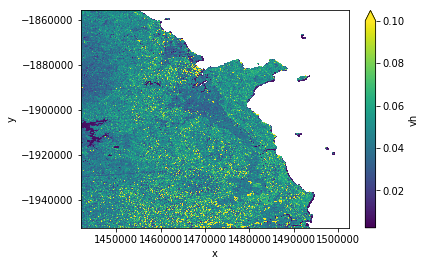

In [24]:
radar.plot(vmax=0.1)

In [25]:
radar

<xarray.DataArray 'vh' (y: 966, x: 604)>
array([[ 0.058245,  0.04679 ,  0.04785 , ...,       nan,       nan,       nan],
       [ 0.054506,  0.039668,  0.061154, ...,       nan,       nan,       nan],
       [ 0.047109,  0.048089,  0.05155 , ...,       nan,       nan,       nan],
       ..., 
       [ 0.040367,  0.066628,  0.042082, ...,       nan,       nan,       nan],
       [ 0.048498,  0.037806,  0.04956 , ...,       nan,       nan,       nan],
       [ 0.049069,  0.045052,  0.048126, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...

In [27]:
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    import xarray
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=None, src_nodata=None):
    """Blit like"""
    import rasterio
    with rasterio.open(file) as src:
        assert src.indexes == (1,) # assume single band
        band = rasterio.band(src, 1) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata,
                                src_nodata=src_nodata)
    return numpy_to_xarray(array, geobox, name)


In [28]:
mz = rasterfile_to_xarray('/g/data/w85/radar_grad/classify/mz_orig.img', z.geobox, nodata=np.nan, src_nodata=-999.5)
cats = rasterfile_to_xarray('/g/data/w85/radar_grad/classify/terrain.img', z.geobox)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  """


In [29]:
mz

<xarray.DataArray (y: 3861, x: 2413)>
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       ..., 
       [ 0.959,  0.959,  0.959, ...,  0.973,  0.973,  0.973],
       [ 0.945,  0.959,  0.959, ...,  0.973,  0.973,  0.973],
       [ 0.959,  0.959,  0.959, ...,  0.973,  0.973,  0.973]], dtype=float32)
Coordinates:
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Attributes:
    crs:      epsg:3577

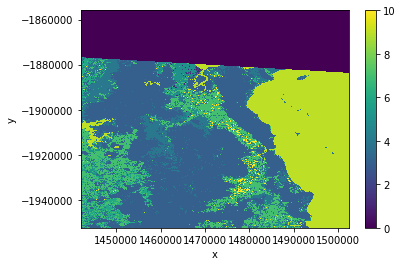

In [30]:
cats.plot()

# Now we want to plot a scatter of radar vs cat data

In [31]:
cats

<xarray.DataArray (y: 3861, x: 2413)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [7, 7, 7, ..., 9, 9, 9],
       [6, 7, 7, ..., 9, 9, 9],
       [7, 7, 7, ..., 9, 9, 9]], dtype=uint8)
Coordinates:
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Attributes:
    crs:      epsg:3577

In [32]:
x

<xarray.Dataset>
Dimensions:  (time: 1, x: 2413, y: 3861)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-15T19:51:53.566905
  * y        (y) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
  * x        (x) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
Data variables:
    vh       (time, y, x) float32 0.0275116 0.0315146 0.0429633 0.0525707 ...
    vv       (time, y, x) float32 0.395897 0.216501 0.150688 0.11122 ...
Attributes:
    crs:      epsg:3577

In [33]:
# Need to get the x and cats data into a single list using 
flatcats = cats.stack(cat = ('x','y'))
flatx = x.vh.stack(vh = ('x','y'))
# Check that they are still looking good
print(flatcats)
print(flatx)

<xarray.DataArray (cat: 9316593)>
array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)
Coordinates:
  * cat      (cat) MultiIndex
  - x        (cat) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
  - y        (cat) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
Attributes:
    crs:      epsg:3577
<xarray.DataArray 'vh' (time: 1, vh: 9316593)>
array([[ 0.027512,  0.065985,  0.052309, ...,  0.      ,  0.      ,  0.      ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-04-15T19:51:53.566905
  * vh       (vh) MultiIndex
  - x        (vh) float64 1.442e+06 1.442e+06 1.442e+06 1.442e+06 1.442e+06 ...
  - y        (vh) float64 -1.856e+06 -1.856e+06 -1.856e+06 -1.856e+06 ...
Attributes:
    nodata:   0
    units:    1
    crs:      epsg:3577


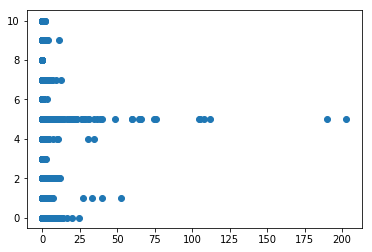

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

In [34]:
#If they are looking good, we can now do our scatter plot
import matplotlib.pyplot as plt
import numpy as np
#fig, ax = plt.subplots()
#ax.scatter(flatx, flatcats)
plt.scatter(flatx, flatcats)
plt.show()
# We want to limit the xaxis scale to 0-0.10 - xlimit?
plt.set_xlim([0, 0.10])
# Add axes labels (radar and Mzcat)(label categ.)


In [ ]:
# A histogram of our flat data
plt.hist(flatx, 50)
plt.show()

In [ ]:
bababa